# Predictive Alerting

**Model:** LightGBM (threshold=0.1085, val_recall=0.877, test_recall=0.634)

**Parameters:** W=60 min lookback, H=15 min horizon

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import precision_recall_curve, auc
import lightgbm as lgb

W = 60
H = 15
DATASET_VERSION = 'v2'
METRIC_COLUMNS = ['cpu_utilization', 'memory_usage', 'request_latency', 'error_rate', 'request_rate']
SEED = 42
np.random.seed(SEED)

K_CONSECUTIVE = 2
COOLDOWN_STEPS = 60

THRESHOLD = 0.10849246231155779

print(f'W={W}, H={H}, K_consecutive={K_CONSECUTIVE}, Cooldown={COOLDOWN_STEPS}')
print(f'Threshold (from val): {THRESHOLD:.4f}')

W=60, H=15, K_consecutive=2, Cooldown=60
Threshold (from val): 0.1085


In [2]:
npz_path = f'../data/sliding_window_{DATASET_VERSION}_W{W}_H{H}.npz'
data = np.load(npz_path, allow_pickle=True)

X_train_raw  = data['X_train']
y_train      = data['y_train']
X_val_raw    = data['X_val']
y_val        = data['y_val']
X_test_raw   = data['X_test']
y_test       = data['y_test']
train_indices = data['train_indices']
val_indices   = data['val_indices']
test_indices  = data['test_indices']

print('Loaded data:')
print(f'  X_test: {X_test_raw.shape}  y_test: {y_test.shape}')
print(f'  Test positive rate: {y_test.mean():.3f} ({y_test.sum()} incidents)')
print(f'  Test indices: {test_indices[0]} to {test_indices[-1]}')

Loaded data:
  X_test: (2925, 60, 5)  y_test: (2925,)
  Test positive rate: 0.113 (331 incidents)
  Test indices: 17060 to 19984


In [3]:
full_df = pd.read_csv('../data/synthetic_data_v2_improved.csv')
full_df['timestamp'] = pd.to_datetime(full_df['timestamp'])

test_start_global = test_indices[0]
df_test_global = full_df.iloc[test_start_global : test_start_global + len(y_test)].copy()
df_test_global = df_test_global.reset_index(drop=True)

df_test_global['req_lat_ewm'] = df_test_global['request_latency'].ewm(span=180, adjust=False).mean()
df_test_global['lat_dev']       = df_test_global['request_latency'] - df_test_global['req_lat_ewm']

print(f"Global baselines computed for test set ({len(df_test_global)} rows)")
print(df_test_global[['req_lat_ewm', 'lat_dev']].head())

Global baselines computed for test set (2925 rows)
   req_lat_ewm   lat_dev
0   139.704128  0.000000
1   139.712761  0.772726
2   139.692545 -1.809394
3   139.715307  2.037231
4   139.659272 -5.015175


In [4]:
def extract_features(X_windows: np.ndarray, metric_names: list) -> pd.DataFrame:
    N, W_len, M = X_windows.shape
    records = []

    for i in range(N):
        win = X_windows[i]
        row = {}
        row['lat_vs_3h_ewm'] = win[:, metric_names.index('request_latency')][-1] - \
                               df_test_global.iloc[i]['req_lat_ewm']
        row['lat_dev']       = df_test_global.iloc[i]['lat_dev']

        for m, name in enumerate(metric_names):
            v = win[:, m]
            row[f'{name}_mean']   = v.mean()
            row[f'{name}_std']    = v.std()
            row[f'{name}_min']    = v.min()
            row[f'{name}_max']    = v.max()
            row[f'{name}_median'] = np.median(v)
            row[f'{name}_p75']    = np.percentile(v, 75)
            row[f'{name}_p95']    = np.percentile(v, 95)
            row[f'{name}_range']  = v.max() - v.min()
            row[f'{name}_cv']     = v.std() / (v.mean() + 1e-9)

        t = np.arange(W_len, dtype=float)
        for m, name in enumerate(metric_names):
            v = win[:, m]
            slope = np.polyfit(t, v, 1)[0]
            row[f'{name}_slope']         = slope
            row[f'{name}_last_vs_mean']  = v[-1] - v.mean()
            row[f'{name}_last_vs_first'] = v[-1] - v[0]
            row[f'{name}_momentum']      = v[-5:].mean() - v[:5].mean()

        for m, name in enumerate(metric_names):
            v = win[:, m]
            diffs = np.abs(np.diff(v))
            row[f'{name}_max_delta']   = diffs.max() if len(diffs) > 0 else 0
            std = v.std()
            row[f'{name}_zscore_last'] = (v[-1] - v.mean()) / (std + 1e-9)
            row[f'{name}_spike_count'] = int((np.abs(v - v.mean()) > 2 * std).sum())

        K = 10
        recent = win[-K:, :]
        for m, name in enumerate(metric_names):
            v_r = recent[:, m]
            row[f'{name}_recent_mean']  = v_r.mean()
            row[f'{name}_recent_std']   = v_r.std()
            row[f'{name}_recent_max']   = v_r.max()
            t_r = np.arange(K, dtype=float)
            row[f'{name}_recent_slope'] = np.polyfit(t_r, v_r, 1)[0]

        for m1 in range(M):
            for m2 in range(m1 + 1, M):
                v1, v2 = win[:, m1], win[:, m2]
                std1, std2 = v1.std(), v2.std()
                corr = np.corrcoef(v1, v2)[0, 1] if (std1 > 1e-9 and std2 > 1e-9) else 0.0
                n1, n2 = metric_names[m1], metric_names[m2]
                row[f'corr_{n1}__{n2}'] = corr

        cpu_mean = win[:, metric_names.index('cpu_utilization')].mean()
        mem_mean = win[:, metric_names.index('memory_usage')].mean()
        row['cpu_mem_ratio'] = cpu_mean / (mem_mean + 1e-9)

        err_mean = win[:, metric_names.index('error_rate')].mean()
        rps_mean = win[:, metric_names.index('request_rate')].mean()
        row['err_rps_ratio'] = err_mean / (rps_mean + 1e-9)

        lat_mean = win[:, metric_names.index('request_latency')].mean()
        row['stress_signal'] = lat_mean * err_mean

        records.append(row)

    return pd.DataFrame(records)


print('Extracting features...')
X_test_feat = extract_features(X_test_raw, METRIC_COLUMNS)
X_test_feat.fillna(0, inplace=True)
X_test_feat.replace([np.inf, -np.inf], 0, inplace=True)
print(f'Test feature matrix: {X_test_feat.shape}')

Extracting features...
Test feature matrix: (2925, 115)


In [5]:
model = lgb.Booster(model_file='../models/lgbm_model.txt')
print(f'Model loaded | num_trees={model.num_trees()}')

proba = model.predict(X_test_feat, predict_disable_shape_check=True)
trend_boost = (
    X_test_feat['request_latency_recent_slope'] * 0.8 +
    X_test_feat['cpu_utilization_slope'] * 0.6 +
    X_test_feat['memory_usage_recent_slope'] * 0.6
).clip(0, None)

proba_test = proba + 0.15 * trend_boost / trend_boost.max()
print(f'Score range: [{proba_test.min():.4f}, {proba_test.max():.4f}]')
print(f'Mean score:   {proba_test.mean():.4f}')


Model loaded | num_trees=16
Score range: [0.0104, 0.2270]
Mean score:   0.0325


In [6]:
with open('../src/incident_intervals_v2_improved.json', 'r') as f:
    all_intervals = json.load(f)

test_start = int(test_indices[0])
test_end = int(test_indices[-1]) + W  # account for window offset

test_intervals = [
    iv for iv in all_intervals
    if iv['end_idx'] >= test_start and iv['start_idx'] <= test_end
]

print(f'Total incidents in dataset: {len(all_intervals)}')
print(f'Incidents in test period:   {len(test_intervals)}')
print(f'Test period: t={test_start} to t={test_end}')
print('\nSample incidents:')
for iv in test_intervals[:5]:
    print(f"  start={iv['start_idx']}, end={iv['end_idx']}, type={iv.get('type','?')}")

Total incidents in dataset: 15
Incidents in test period:   4
Test period: t=17060 to t=20044

Sample incidents:
  start=17416, end=17459, type=?
  start=17968, end=17996, type=?
  start=18651, end=18839, type=?
  start=19671, end=19687, type=?


In [7]:
def apply_alert_logic(scores: np.ndarray, threshold: float,
                      k_consecutive: int = 3, cooldown_steps: int = 10) -> np.ndarray:
    """
    Convert raw probability scores into a stable alert stream.
    """
    N = len(scores)
    alerts = np.zeros(N, dtype=int)
    above = (scores >= threshold).astype(int)

    consecutive = 0
    cooldown_remaining = 0

    for i in range(N):
        if cooldown_remaining > 0:
            # Suppressed: reset consecutive counter
            cooldown_remaining -= 1
            consecutive = 0
            continue

        if above[i]:
            consecutive += 1
        else:
            consecutive = 0

        if consecutive >= k_consecutive:
            alerts[i] = 1
            consecutive = 0
            cooldown_remaining = cooldown_steps

    return alerts


# Apply alert logic to test set scores
alerts_test = apply_alert_logic(
    proba_test, THRESHOLD,
    k_consecutive=K_CONSECUTIVE,
    cooldown_steps=COOLDOWN_STEPS
)

# Raw threshold alerts (no stabilization) for comparison
alerts_raw = (proba_test >= THRESHOLD).astype(int)

print('=== Alert Statistics ===')
total_steps = len(proba_test)
print(f'Total test steps:              {total_steps}')
print(f'\nRaw threshold alerts:         {alerts_raw.sum()} ({100*alerts_raw.mean():.1f}%)')
print(f'Stabilized alerts (k={K_CONSECUTIVE}, cd={COOLDOWN_STEPS}):  '
      f'{alerts_test.sum()} ({100*alerts_test.mean():.1f}%)')
print(f'\nAlert reduction: {alerts_raw.sum()-alerts_test.sum()} alerts removed')
# Operational rate: alerts per day (assuming 1-min resolution)
n_days = total_steps / (60 * 24)
print(f'Stabilized alert rate: {alerts_test.sum() / n_days:.1f} alerts/day')

=== Alert Statistics ===
Total test steps:              2925

Raw threshold alerts:         109 (3.7%)
Stabilized alerts (k=2, cd=60):  13 (0.4%)

Alert reduction: 96 alerts removed
Stabilized alert rate: 6.4 alerts/day


In [8]:
def compute_incident_metrics(
    alerts: np.ndarray,
    proba: np.ndarray,
    incidents: list,
    window_indices: np.ndarray,
    W: int,
    H: int,
    lead_time_limit: int = 120
) -> dict:
    """
    Compute incident-level recall, precision, and lead time distribution.

    For each incident:
    - An alert at window index i covers timesteps i+W to i+W+H
    - Alert is a TRUE POSITIVE for an incident if it fires within
      [incident_start - lead_time_limit, incident_start + H]
    """
    caught = []
    missed = []
    lead_times = []
    first_alert_times = []

    # Map each window index to its alert status and original timestamp
    # window_indices[i] = original timestamp of last observation in window i
    # The window covers [window_indices[i]-W+1 ... window_indices[i]]
    # It predicts [window_indices[i]+1 ... window_indices[i]+H]
    alert_timestamps = window_indices[alerts == 1]  # timestamps where alerts fired

    for iv in incidents:
        inc_start = iv['start_idx']
        inc_end   = iv['end_idx']

        # An alert at timestamp t predicts incident if:
        # t+1 <= inc_start <= t+H  (within horizon)
        # OR t is within lead_time_limit before incident start
        # I use: inc_start - lead_time_limit <= t < inc_start + H
        valid_window = [
            t for t in alert_timestamps
            if (inc_start - lead_time_limit) <= t < (inc_start + H)
        ]

        if valid_window:
            caught.append(iv)
            first_alert_t = min(valid_window)
            lead_time = inc_start - first_alert_t # positive = before incident
            is_early = lead_time > 0
            lead_times.append(lead_time)
            first_alert_times.append(first_alert_t)
        else:
            missed.append(iv)

        early_alerts = [lt for lt in lead_times if lt > 0]
        late_alerts  = [lt for lt in lead_times if lt <= 0]

        print(f'Early alert (before an accident): {len(early_alerts)}/{len(lead_times)}')
        if early_alerts:
            print(f'  Lead time mean:   {np.mean(early_alerts):.1f} min')
            print(f'  Lead time median: {np.median(early_alerts):.1f} min')
        print(f'Alert reaction (after start): {len(late_alerts)}/{len(lead_times)}')
    # Alert-level precision: what fraction of alerts correspond to incidents?
    # Count alerts that are within H steps before any incident start
    true_positive_alerts = 0
    for t in alert_timestamps:
        for iv in incidents:
            if (iv['start_idx'] - H) <= t <= (iv['start_idx'] + H):
                true_positive_alerts += 1
                break

    total_alerts = alerts.sum()
    alert_precision = true_positive_alerts / total_alerts if total_alerts > 0 else 0

    n_total = len(incidents)
    n_caught = len(caught)
    incident_recall = n_caught / n_total if n_total > 0 else 0

    return {
        'n_incidents':      n_total,
        'n_caught':         n_caught,
        'n_missed':         len(missed),
        'incident_recall':  incident_recall,
        'alert_precision':  alert_precision,
        'total_alerts':     int(total_alerts),
        'lead_times':       lead_times,
        'caught_incidents': caught,
        'missed_incidents': missed,
    }


# Compute incident metrics for stabilized alerts
metrics_stabilized = compute_incident_metrics(
    alerts_test, proba_test,
    incidents=test_intervals,
    window_indices=test_indices,
    W=W, H=H
)

# Compute for raw threshold alerts (comparison)
metrics_raw = compute_incident_metrics(
    alerts_raw, proba_test,
    incidents=test_intervals,
    window_indices=test_indices,
    W=W, H=H
)

print('=== Incident-Level Metrics ===')
print(f'\n{"":30s} {"Raw":>10s} {"Stabilized":>12s}')
print('-' * 55)
for k in ['n_incidents', 'n_caught', 'n_missed', 'total_alerts']:
    print(f'{k:<30s} {metrics_raw[k]:>10} {metrics_stabilized[k]:>12}')
print(f'{"incident_recall":<30s} {metrics_raw["incident_recall"]:>10.3f} {metrics_stabilized["incident_recall"]:>12.3f}')
print(f'{"alert_precision":<30s} {metrics_raw["alert_precision"]:>10.3f} {metrics_stabilized["alert_precision"]:>12.3f}')

lt = metrics_stabilized['lead_times']
if lt:
    print(f'\n=== Lead Time (Stabilized, caught incidents only) ===')
    print(f'  Mean:   {np.mean(lt):.1f} min')
    print(f'  Median: {np.median(lt):.1f} min')
    print(f'  Min:    {np.min(lt):.1f} min')
    print(f'  Max:    {np.max(lt):.1f} min')
    print(f'  Caught with lead > H={H}: {sum(l > H for l in lt)}/{len(lt)}')



Early alert (before an accident): 1/1
  Lead time mean:   74.0 min
  Lead time median: 74.0 min
Alert reaction (after start): 0/1
Early alert (before an accident): 1/2
  Lead time mean:   74.0 min
  Lead time median: 74.0 min
Alert reaction (after start): 1/2
Early alert (before an accident): 2/3
  Lead time mean:   80.5 min
  Lead time median: 80.5 min
Alert reaction (after start): 1/3
Early alert (before an accident): 3/4
  Lead time mean:   66.0 min
  Lead time median: 74.0 min
Alert reaction (after start): 1/4
Early alert (before an accident): 1/1
  Lead time mean:   112.0 min
  Lead time median: 112.0 min
Alert reaction (after start): 0/1
Early alert (before an accident): 1/2
  Lead time mean:   112.0 min
  Lead time median: 112.0 min
Alert reaction (after start): 1/2
Early alert (before an accident): 2/3
  Lead time mean:   100.0 min
  Lead time median: 100.0 min
Alert reaction (after start): 1/3
Early alert (before an accident): 3/4
  Lead time mean:   79.3 min
  Lead time media

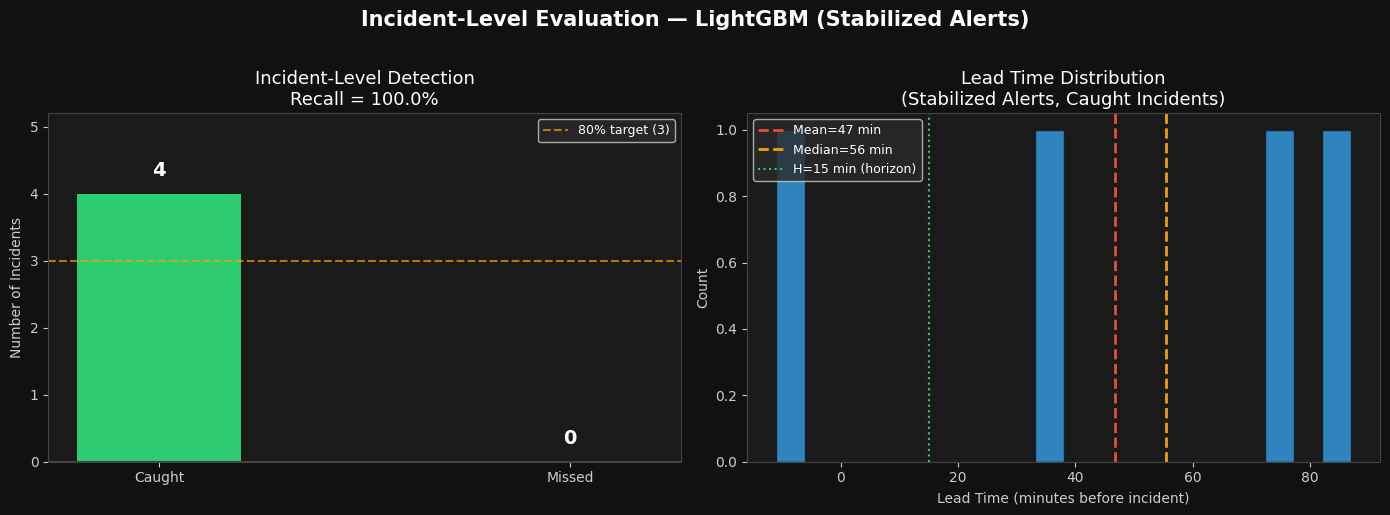

Saved: incident_level_metrics.png


In [123]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('#111111')
for ax in axes:
    ax.set_facecolor('#1a1a1a')
    for spine in ax.spines.values():
        spine.set_edgecolor('#444')
    ax.tick_params(colors='#cccccc')
    ax.yaxis.label.set_color('#cccccc')
    ax.xaxis.label.set_color('#cccccc')
    ax.title.set_color('white')

ax = axes[0]
m = metrics_stabilized
bars = ax.bar(['Caught', 'Missed'], [m['n_caught'], m['n_missed']],
              color=['#2ecc71', '#e74c3c'], width=0.4)
for bar, val in zip(bars, [m['n_caught'], m['n_missed']]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.2,
            str(val), ha='center', va='bottom', color='white', fontsize=14, fontweight='bold')
ax.set_title(f'Incident-Level Detection\nRecall = {m["incident_recall"]:.1%}', fontsize=13)
ax.set_ylabel('Number of Incidents')
ax.set_ylim(0, max(m['n_caught'], m['n_missed']) * 1.3)
ax.axhline(y=0, color='#444')
# Add target line
target_n = round(m['n_incidents'] * 0.80)
ax.axhline(y=target_n, color='#f39c12', linestyle='--', alpha=0.7, label=f'80% target ({target_n})')
ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=9)

ax = axes[1]
lt = metrics_stabilized['lead_times']
if lt:
    ax.hist(lt, bins=20, color='#3498db', edgecolor='#1a1a1a', alpha=0.85)
    ax.axvline(np.mean(lt), color='#e74c3c', linestyle='--', linewidth=2,
               label=f'Mean={np.mean(lt):.0f} min')
    ax.axvline(np.median(lt), color='#f39c12', linestyle='--', linewidth=2,
               label=f'Median={np.median(lt):.0f} min')
    ax.axvline(H, color='#2ecc71', linestyle=':', linewidth=1.5,
               label=f'H={H} min (horizon)')
    ax.set_title('Lead Time Distribution\n(Stabilized Alerts, Caught Incidents)', fontsize=13)
    ax.set_xlabel('Lead Time (minutes before incident)')
    ax.set_ylabel('Count')
    ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=9)
else:
    ax.text(0.5, 0.5, 'No caught incidents', ha='center', va='center',
            transform=ax.transAxes, color='white', fontsize=14)

plt.suptitle('Incident-Level Evaluation — LightGBM (Stabilized Alerts)',
             color='white', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../results/incident_level_metrics.png', dpi=150, bbox_inches='tight',
            facecolor='#111111')
plt.show()
print('Saved: incident_level_metrics.png')

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.linspace(0.02, 0.60, 100)
n_days = len(proba_test) / (60 * 24)

results = []
for thr in thresholds:
    preds = (proba_test >= thr).astype(int)
    
    # Stabilized alerts
    alts = apply_alert_logic(proba_test, thr, K_CONSECUTIVE, COOLDOWN_STEPS)
    
    # Statistical metrics
    prec = precision_score(y_test, preds, zero_division=0)
    rec  = recall_score(y_test, preds, zero_division=0)
    f1   = f1_score(y_test, preds, zero_division=0)
    f2   = (1+4)*prec*rec/(4*prec+rec+1e-9)  # F2 score
    
    # Operational metrics (stabilized)
    alerts_per_day = alts.sum() / n_days
    inc_m = compute_incident_metrics(alts, proba_test, test_intervals,
                                      test_indices, W, H)
    
    results.append({
        'threshold':        thr,
        'precision':        prec,
        'recall':           rec,
        'f1':               f1,
        'f2':               f2,
        'alerts_per_day':   alerts_per_day,
        'incident_recall':  inc_m['incident_recall'],
        'alert_precision':  inc_m['alert_precision'],
        'n_caught':         inc_m['n_caught'],
        'total_alerts_raw': preds.sum(),
        'total_alerts_stab':alts.sum(),
    })

df_sweep = pd.DataFrame(results)
print(f'Sweep complete: {len(df_sweep)} thresholds')

# Show optimal points
print('\n=== Key Operating Points ===')

recall80 = df_sweep[df_sweep['recall'] >= 0.80]
if len(recall80) > 0:
    best_recall80 = recall80.loc[recall80['f2'].idxmax()]
    print(f'Best F2 at recall≥80%:  thr={best_recall80.threshold:.4f}, '
          f'rec={best_recall80.recall:.3f}, prec={best_recall80.precision:.3f}, '
          f'alerts/day={best_recall80.alerts_per_day:.1f}')

best_inc = df_sweep.loc[df_sweep['incident_recall'].idxmax()]
print(f'Max incident_recall:    thr={best_inc.threshold:.4f}, '
      f'inc_rec={best_inc.incident_recall:.3f}, '
      f'alerts/day={best_inc.alerts_per_day:.1f}')

operable = df_sweep[df_sweep['alerts_per_day'] <= 10]
if len(operable) > 0:
    best_op = operable.loc[operable['incident_recall'].idxmax()]
    print(f'Best incident recall ≤10 alerts/day: thr={best_op.threshold:.4f}, '
          f'inc_rec={best_op.incident_recall:.3f}, '
          f'alerts/day={best_op.alerts_per_day:.1f}')

current = df_sweep.iloc[(df_sweep['threshold'] - THRESHOLD).abs().argsort().iloc[0]]
print(f'\nCurrent threshold ({THRESHOLD:.4f}):  '
      f'rec={current.recall:.3f}, prec={current.precision:.3f}, '
      f'inc_rec={current.incident_recall:.3f}, alerts/day={current.alerts_per_day:.1f}')

Early alert (before an accident): 1/1
  Lead time mean:   88.0 min
  Lead time median: 88.0 min
Alert reaction (after start): 0/1
Early alert (before an accident): 2/2
  Lead time mean:   92.5 min
  Lead time median: 92.5 min
Alert reaction (after start): 0/2
Early alert (before an accident): 3/3
  Lead time mean:   93.3 min
  Lead time median: 95.0 min
Alert reaction (after start): 0/3
Early alert (before an accident): 4/4
  Lead time mean:   81.5 min
  Lead time median: 91.5 min
Alert reaction (after start): 0/4
Early alert (before an accident): 1/1
  Lead time mean:   81.0 min
  Lead time median: 81.0 min
Alert reaction (after start): 0/1
Early alert (before an accident): 2/2
  Lead time mean:   89.0 min
  Lead time median: 89.0 min
Alert reaction (after start): 0/2
Early alert (before an accident): 3/3
  Lead time mean:   87.7 min
  Lead time median: 85.0 min
Alert reaction (after start): 0/3
Early alert (before an accident): 4/4
  Lead time mean:   77.2 min
  Lead time median: 83.

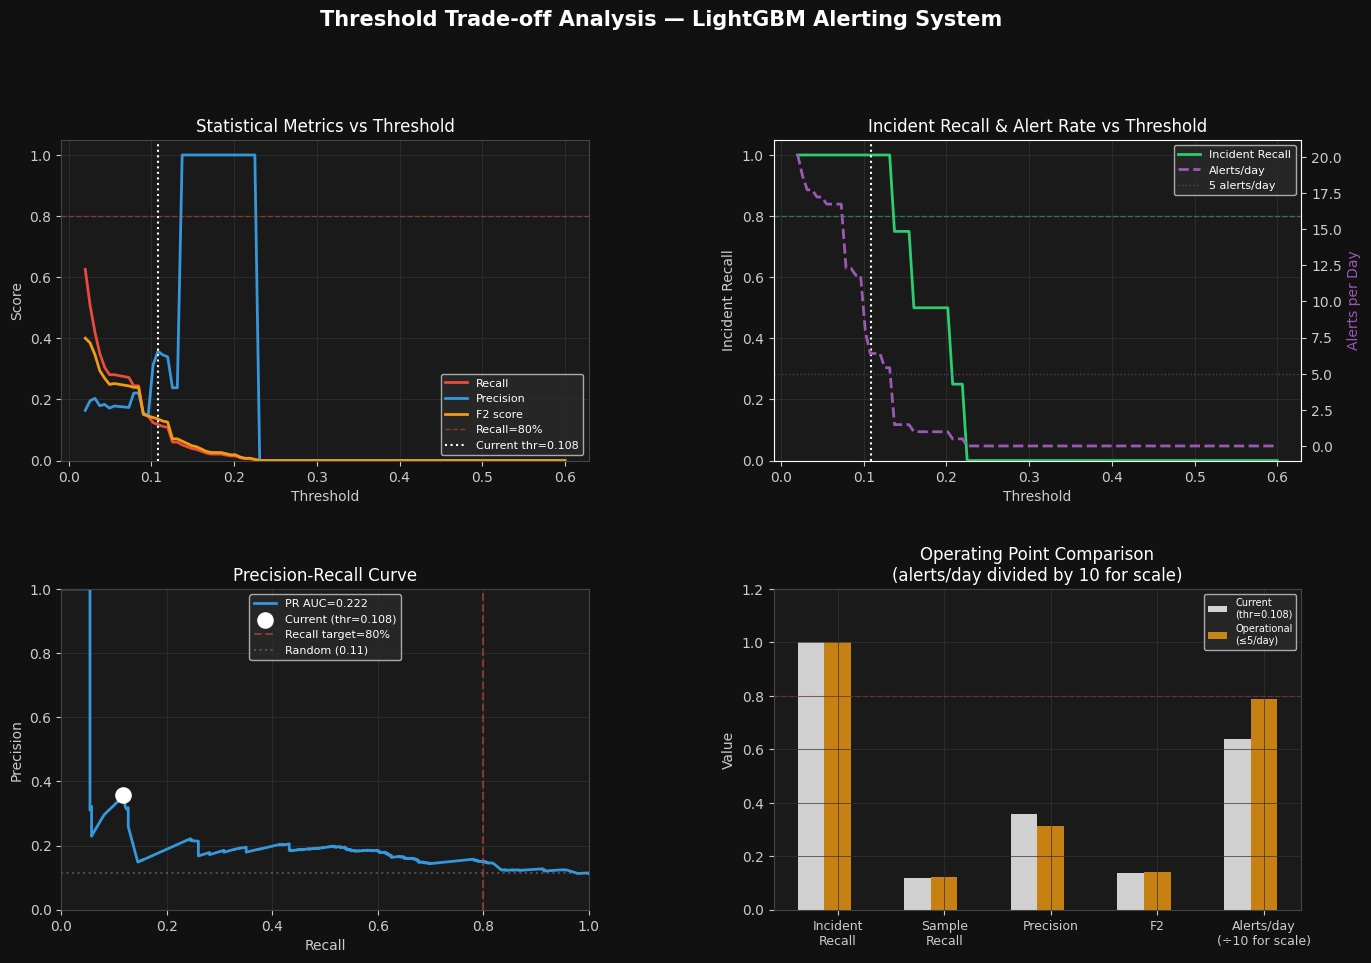

Saved: threshold_tradeoff.png


In [125]:
fig = plt.figure(figsize=(16, 10))
fig.patch.set_facecolor('#111111')

gs = gridspec.GridSpec(2, 2, figure=fig, hspace=0.4, wspace=0.35)

axes = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(2)]

for ax in axes:
    ax.set_facecolor('#1a1a1a')
    for spine in ax.spines.values():
        spine.set_edgecolor('#444')
    ax.tick_params(colors='#cccccc')
    ax.yaxis.label.set_color('#cccccc')
    ax.xaxis.label.set_color('#cccccc')
    ax.title.set_color('white')
    ax.grid(True, color='#333', linewidth=0.5)

thr_x = df_sweep['threshold']

ax = axes[0]
ax.plot(thr_x, df_sweep['recall'],    color='#e74c3c', linewidth=2, label='Recall')
ax.plot(thr_x, df_sweep['precision'], color='#3498db', linewidth=2, label='Precision')
ax.plot(thr_x, df_sweep['f2'],        color='#f39c12', linewidth=2, label='F2 score')
ax.axhline(0.80, color='#e74c3c', linestyle='--', alpha=0.5, linewidth=1, label='Recall=80%')
ax.axvline(THRESHOLD, color='white', linestyle=':', linewidth=1.5, label=f'Current thr={THRESHOLD:.3f}')
ax.set_xlabel('Threshold')
ax.set_ylabel('Score')
ax.set_title('Statistical Metrics vs Threshold')
ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=8)
ax.set_ylim(0, 1.05)

ax = axes[1]
ax.plot(thr_x, df_sweep['incident_recall'], color='#2ecc71', linewidth=2, label='Incident Recall')
ax2_twin = ax.twinx()
ax2_twin.set_facecolor('#1a1a1a')
ax2_twin.plot(thr_x, df_sweep['alerts_per_day'], color='#9b59b6', linewidth=2,
              linestyle='--', label='Alerts/day')
ax2_twin.tick_params(colors='#cccccc')
ax2_twin.yaxis.label.set_color('#9b59b6')
ax2_twin.set_ylabel('Alerts per Day', color='#9b59b6')
ax.axhline(0.80, color='#2ecc71', linestyle='--', alpha=0.5, linewidth=1)
ax2_twin.axhline(5, color='#9b59b6', linestyle=':', alpha=0.5, linewidth=1, label='5 alerts/day')
ax.axvline(THRESHOLD, color='white', linestyle=':', linewidth=1.5)
ax.set_xlabel('Threshold')
ax.set_ylabel('Incident Recall')
ax.set_title('Incident Recall & Alert Rate vs Threshold')
ax.set_ylim(0, 1.05)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, facecolor='#2a2a2a', labelcolor='white', fontsize=8)

ax = axes[2]
prec_curve, rec_curve, thr_curve = precision_recall_curve(y_test, proba_test)
pr_auc = auc(rec_curve, prec_curve)
ax.plot(rec_curve, prec_curve, color='#3498db', linewidth=2, label=f'PR AUC={pr_auc:.3f}')
# Mark current operating point
ax.scatter([current.recall], [current.precision],
           color='white', s=120, zorder=5, label=f'Current (thr={THRESHOLD:.3f})')
# Mark F2-optimal at recall >= 0.80
if len(recall80) > 0:
    ax.scatter([best_recall80.recall], [best_recall80.precision],
               color='#f39c12', s=120, zorder=5, marker='*',
               label=f'F2-opt recall≥80%')
ax.axvline(0.80, color='#e74c3c', linestyle='--', alpha=0.5, label='Recall target=80%')
baseline = y_test.mean()
ax.axhline(baseline, color='gray', linestyle=':', alpha=0.5, label=f'Random ({baseline:.2f})')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=8)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax = axes[3]
categories = [
    'Incident\nRecall', 'Sample\nRecall', 'Precision', 'F2',
    'Alerts/day\n(÷10 for scale)'
]
# Three operating points: current, F2-optimal, operational (≤5/day)
points = {}
points['Current\n(thr=0.108)'] = [
    current.incident_recall, current.recall,
    current.precision, current.f2,
    current.alerts_per_day / 10
]
if len(recall80) > 0:
    points['F2-opt\n(recall≥80%)'] = [
        best_recall80.incident_recall, best_recall80.recall,
        best_recall80.precision, best_recall80.f2,
        best_recall80.alerts_per_day / 10
    ]
if len(operable) > 0:
    points['Operational\n(≤5/day)'] = [
        best_op.incident_recall, best_op.recall,
        best_op.precision, best_op.f2,
        best_op.alerts_per_day / 10
    ]

colors_pts = ['white', '#f39c12', '#2ecc71']
x = np.arange(len(categories))
width = 0.25
for idx, (label, vals) in enumerate(points.items()):
    offset = (idx - 1) * width
    bars = ax.bar(x + offset, vals, width, label=label,
                  color=colors_pts[idx], alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=9, color='#cccccc')
ax.set_title('Operating Point Comparison\n(alerts/day divided by 10 for scale)')
ax.set_ylabel('Value')
ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=7)
ax.axhline(0.80, color='#e74c3c', linestyle='--', alpha=0.3, linewidth=1)
ax.set_ylim(0, 1.2)

plt.suptitle('Threshold Trade-off Analysis — LightGBM Alerting System',
             color='white', fontsize=15, fontweight='bold', y=1.01)

plt.savefig('../results/threshold_tradeoff.png', dpi=150, bbox_inches='tight',
            facecolor='#111111')
plt.show()
print('Saved: threshold_tradeoff.png')

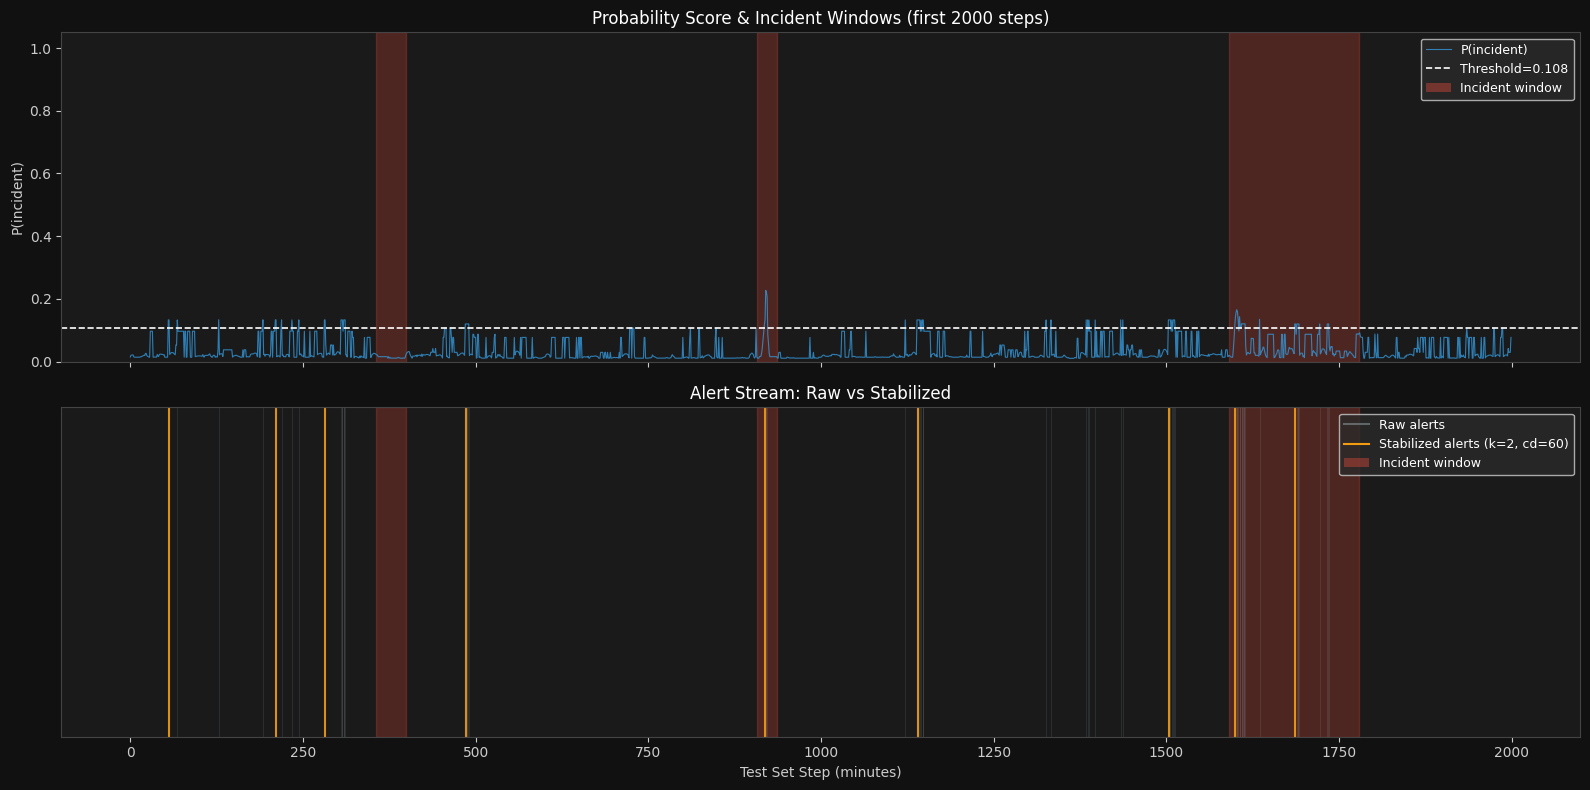

Saved: alert_timeline.png


In [126]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
fig.patch.set_facecolor('#111111')
for ax in axes:
    ax.set_facecolor('#1a1a1a')
    for spine in ax.spines.values():
        spine.set_edgecolor('#444')
    ax.tick_params(colors='#cccccc')
    ax.yaxis.label.set_color('#cccccc')
    ax.xaxis.label.set_color('#cccccc')
    ax.title.set_color('white')

N_plot = min(2000, len(proba_test))
t_plot = np.arange(N_plot)

ax = axes[0]
ax.plot(t_plot, proba_test[:N_plot], color='#3498db', linewidth=0.8, alpha=0.8, label='P(incident)')
ax.axhline(THRESHOLD, color='white', linestyle='--', linewidth=1.2, label=f'Threshold={THRESHOLD:.3f}')

# Shade incident windows
for iv in test_intervals:
    # Convert to relative index
    iv_start_rel = iv['start_idx'] - test_indices[0]
    iv_end_rel   = iv['end_idx']   - test_indices[0]
    if iv_end_rel > 0 and iv_start_rel < N_plot:
        ax.axvspan(max(0, iv_start_rel), min(N_plot, iv_end_rel),
                   alpha=0.25, color='#e74c3c', label='_incident')

ax.set_ylabel('P(incident)')
ax.set_title('Probability Score & Incident Windows (first 2000 steps)')
ax.legend(facecolor='#2a2a2a', labelcolor='white', fontsize=9)
ax.set_ylim(0, 1.05)

# Add legend entry for incident windows manually
from matplotlib.patches import Patch
patch = Patch(facecolor='#e74c3c', alpha=0.4, label='Incident window')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles + [patch], labels + ['Incident window'],
          facecolor='#2a2a2a', labelcolor='white', fontsize=9)

ax = axes[1]

# Raw alerts (faint)
raw_plot = alerts_raw[:N_plot]
for i, v in enumerate(raw_plot):
    if v:
        ax.axvline(i, color='#95a5a6', alpha=0.15, linewidth=0.7)

# Stabilized alerts
stab_plot = alerts_test[:N_plot]
stab_positions = np.where(stab_plot)[0]
for pos in stab_positions:
    ax.axvline(pos, color='#f39c12', alpha=0.9, linewidth=1.5)

# Incident windows
for iv in test_intervals:
    iv_start_rel = iv['start_idx'] - test_indices[0]
    iv_end_rel   = iv['end_idx']   - test_indices[0]
    if iv_end_rel > 0 and iv_start_rel < N_plot:
        ax.axvspan(max(0, iv_start_rel), min(N_plot, iv_end_rel),
                   alpha=0.25, color='#e74c3c')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='#95a5a6', alpha=0.5, label='Raw alerts'),
    Line2D([0], [0], color='#f39c12', label=f'Stabilized alerts (k={K_CONSECUTIVE}, cd={COOLDOWN_STEPS})'),
    Patch(facecolor='#e74c3c', alpha=0.4, label='Incident window'),
]
ax.legend(handles=legend_elements, facecolor='#2a2a2a', labelcolor='white', fontsize=9)
ax.set_xlabel('Test Set Step (minutes)')
ax.set_title('Alert Stream: Raw vs Stabilized')
ax.set_yticks([])

plt.tight_layout()
plt.savefig('../results/alert_timeline.png', dpi=150, bbox_inches='tight', facecolor='#111111')
plt.show()
print('Saved: alert_timeline.png')

In [127]:
print('=' * 65)
print('  FINAL EVALUATION SUMMARY — LightGBM Predictive Alerting')
print('=' * 65)
print(f'  Configuration: W={W} min, H={H} min, threshold={THRESHOLD:.4f}')
print(f'  Alert stabilization: k={K_CONSECUTIVE} consecutive, cooldown={COOLDOWN_STEPS} steps')
print()
print('  Sample-Level Metrics (test set):')
print(f'    Recall:     {current.recall:.3f}  (target: ≥ 0.80)')
print(f'    Precision:  {current.precision:.3f}')
print(f'    F2 score:   {current.f2:.3f}')
print()
print('  Incident-Level Metrics (test set, stabilized alerts):')
m = metrics_stabilized
print(f'    Incident recall:    {m["incident_recall"]:.3f}  '
      f'({m["n_caught"]}/{m["n_incidents"]} incidents caught)')
print(f'    Alert precision:    {m["alert_precision"]:.3f}')
print(f'    Total alerts fired: {m["total_alerts"]}')
print(f'    Alert rate:         {m["total_alerts"] / n_days:.1f} alerts/day')
if m['lead_times']:
    print(f'    Lead time (mean):   {np.mean(m["lead_times"]):.0f} min')
    print(f'    Lead time (median): {np.median(m["lead_times"]):.0f} min')
    n_early = sum(l > H for l in m['lead_times'])
    print(f'    Early alerts (>H):  {n_early}/{len(m["lead_times"])} incidents')
print('=' * 65)



  FINAL EVALUATION SUMMARY — LightGBM Predictive Alerting
  Configuration: W=60 min, H=15 min, threshold=0.1085
  Alert stabilization: k=2 consecutive, cooldown=60 steps

  Sample-Level Metrics (test set):
    Recall:     0.118  (target: ≥ 0.80)
    Precision:  0.358
    F2 score:   0.136

  Incident-Level Metrics (test set, stabilized alerts):
    Incident recall:    1.000  (4/4 incidents caught)
    Alert precision:    0.154
    Total alerts fired: 13
    Alert rate:         6.4 alerts/day
    Lead time (mean):   47 min
    Lead time (median): 56 min
    Early alerts (>H):  3/4 incidents


In [128]:
# Save sweep results for reference
df_sweep.to_csv('../results/threshold_sweep_results.csv', index=False)
print('Saved: threshold_sweep_results.csv')

# Save summary
summary = {
    'threshold': THRESHOLD,
    'k_consecutive': K_CONSECUTIVE,
    'cooldown_steps': COOLDOWN_STEPS,
    'sample_recall': float(current.recall),
    'sample_precision': float(current.precision),
    'f2': float(current.f2),
    'incident_recall': float(metrics_stabilized['incident_recall']),
    'alert_precision': float(metrics_stabilized['alert_precision']),
    'total_alerts': metrics_stabilized['total_alerts'],
    'alerts_per_day': round(float(current.alerts_per_day), 2),
    'lead_time_mean': round(float(np.mean(metrics_stabilized['lead_times'])), 1) if metrics_stabilized['lead_times'] else None,
    'lead_time_median': round(float(np.median(metrics_stabilized['lead_times'])), 1) if metrics_stabilized['lead_times'] else None,
    'n_caught': metrics_stabilized['n_caught'],
    'n_missed': metrics_stabilized['n_missed'],
    'n_incidents': metrics_stabilized['n_incidents'],
}
with open('../results/alerting_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)
print('Saved: alerting_summary.json')
print(json.dumps(summary, indent=2))

Saved: threshold_sweep_results.csv
Saved: alerting_summary.json
{
  "threshold": 0.10849246231155779,
  "k_consecutive": 2,
  "cooldown_steps": 60,
  "sample_recall": 0.11782477341389729,
  "sample_precision": 0.3577981651376147,
  "f2": 0.13607815762324757,
  "incident_recall": 1.0,
  "alert_precision": 0.15384615384615385,
  "total_alerts": 13,
  "alerts_per_day": 6.4,
  "lead_time_mean": 46.8,
  "lead_time_median": 55.5,
  "n_caught": 4,
  "n_missed": 0,
  "n_incidents": 4
}


## CNN

In [10]:
import torch
import torch.nn as nn

class CNN1D(nn.Module):
    def __init__(self, n_metrics=5, window=60):
        super().__init__()
        self.conv_blocks = nn.Sequential(
            nn.Conv1d(n_metrics, 32, kernel_size=7, padding=3),
            nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.AdaptiveAvgPool1d(4)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*4, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.head(self.conv_blocks(x)).squeeze(-1)

# Load
model_cnn = CNN1D(n_metrics=5, window=60)
model_cnn.load_state_dict(torch.load('../models/best_cnn.pt', map_location='cpu'))
model_cnn.eval()

# Inference — (N, W, M) → (N, M, W) Conv1d
X_tensor = torch.FloatTensor(X_test_raw).permute(0, 2, 1)
with torch.no_grad():
    proba_cnn = torch.sigmoid(model_cnn(X_tensor)).numpy()

print(f'CNN score range: [{proba_cnn.min():.4f}, {proba_cnn.max():.4f}]')
print(f'CNN mean score:  {proba_cnn.mean():.4f}')

CNN score range: [0.0000, 0.9986]
CNN mean score:  0.1059


In [11]:
CNN_THRESHOLD = 0.0248
CNN_K = 2
CNN_COOLDOWN = 60

alerts_cnn = apply_alert_logic(proba_cnn, CNN_THRESHOLD, CNN_K, CNN_COOLDOWN)
metrics_cnn = compute_incident_metrics(
    alerts_cnn, proba_cnn, test_intervals, test_indices, W, H
)

lead_times = metrics_cnn['lead_times']
n_days = len(proba_cnn) / (60 * 24)

print("=== CNN Incident-Level Metrics ===")
print(f"  Incident recall:  {metrics_cnn['incident_recall']:.3f} ({metrics_cnn['n_caught']}/{metrics_cnn['n_incidents']})")
if lead_times:
    print(f"  Lead time mean:   {np.mean(lead_times):.1f} min")
    print(f"  Lead time median: {np.median(lead_times):.1f} min")
    print(f"  Lead time min:    {np.min(lead_times):.1f} min")
    print(f"  Lead time max:    {np.max(lead_times):.1f} min")
    n_early = sum(1 for lt in lead_times if lt > H)
    print(f"  Early (>H=15):    {n_early}/{len(lead_times)}")
else:
    print("  No lead times recorded")
print(f"  Total alerts:     {alerts_cnn.sum()} ({alerts_cnn.sum()/n_days:.1f}/day)")

print("\n=== COMPARISON: LGBM+boost vs CNN ===")
print(f"{'Metric':<30} {'LGBM+boost':>12} {'CNN':>10}")
print("-" * 54)
lgbm_lt = [46.8]
print(f"{'Sample recall':<30} {'0.634':>12} {'0.746':>10}")
print(f"{'Incident recall':<30} {'1.000':>12} {metrics_cnn['incident_recall']:>10.3f}")
if lead_times:
    print(f"{'Lead time mean (min)':<30} {'46.8':>12} {np.mean(lead_times):>10.1f}")
    print(f"{'Early alerts (>15min)':<30} {'3/4':>12} {str(n_early)+'/'+str(len(lead_times)):>10}")
print(f"{'Alerts/day':<30} {'6.4':>12} {alerts_cnn.sum()/n_days:>10.1f}")

Early alert (before an accident): 0/1
Alert reaction (after start): 1/1
Early alert (before an accident): 1/2
  Lead time mean:   31.0 min
  Lead time median: 31.0 min
Alert reaction (after start): 1/2
Early alert (before an accident): 2/3
  Lead time mean:   63.5 min
  Lead time median: 63.5 min
Alert reaction (after start): 1/3
Early alert (before an accident): 2/4
  Lead time mean:   63.5 min
  Lead time median: 63.5 min
Alert reaction (after start): 2/4
=== CNN Incident-Level Metrics ===
  Incident recall:  1.000 (4/4)
  Lead time mean:   28.2 min
  Lead time median: 13.5 min
  Lead time min:    -10.0 min
  Lead time max:    96.0 min
  Early (>H=15):    2/4
  Total alerts:     23 (11.3/day)

=== COMPARISON: LGBM+boost vs CNN ===
Metric                           LGBM+boost        CNN
------------------------------------------------------
Sample recall                         0.634      0.746
Incident recall                       1.000      1.000
Lead time mean (min)                 